In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
import matplotlib
from itertools import product
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


%matplotlib inline

In [2]:
#change file name/path to match yours

dataimport = pd.read_excel('globalterrorismdb_0919dist.xlsx')

In [3]:
#drop columns with more than 20% missing
dataimport=dataimport.replace({'':np.nan})
dataimport = dataimport.dropna(thresh=0.8*len(dataimport), axis=1)

#small program to check percentage of missings in each column
def missing(dff):
    print("Missing values in %")
    print(round((dff.isnull().sum() * 100/ len(dff)),2).sort_values(ascending=False))

#drop string variables
##also dropped lati/longitude here since imputation wouldn't make sense and we have lots of locational variables already

data = dataimport[['eventid', 'iyear', 'imonth','iday','country','doubtterr', 'multiple','success','suicide',
                     'attacktype1','targtype1','targsubtype1','natlty1','guncertain1','individual',
                   'weaptype1','weapsubtype1','nwound', 'property','ishostkid', 'nkill']]

data = data.sort_values('nkill')

data.head()

,eventid,iyear,imonth,iday,country,doubtterr,multiple,success,suicide,attacktype1,...,targsubtype1,natlty1,guncertain1,individual,weaptype1,weapsubtype1,nwound,property,ishostkid,nkill
96718,201005270004,2010,5,27,95,0,0,1,0,3,...,67.0,95.0,0.0,0,6,17.0,2.0,1,0.0,0.0
104352,201111300009,2011,11,30,95,0,0,1,0,3,...,69.0,95.0,0.0,0,6,15.0,7.0,-9,0.0,0.0
104347,201111290047,2011,11,28,43,0,0,1,0,3,...,27.0,43.0,0.0,0,6,17.0,0.0,0,0.0,0.0
104345,201111290042,2011,11,29,78,0,0,1,0,7,...,21.0,78.0,1.0,0,8,20.0,0.0,1,0.0,0.0
104342,201111290028,2011,11,29,209,1,0,1,0,3,...,35.0,209.0,0.0,0,6,16.0,5.0,1,0.0,0.0


In [4]:
#imputations

data['nwound'] = data['nwound'].fillna(data['nwound'].mean())
data['weapsubtype1'] = data['weapsubtype1'].fillna(data['weapsubtype1'].mode().iloc[0])
data['targsubtype1'] = data['targsubtype1'].fillna(data['targsubtype1'].mode().iloc[0])
data['natlty1'] = data['natlty1'].fillna(data['natlty1'].mode().iloc[0])
data['guncertain1'] = data['guncertain1'].fillna(data['guncertain1'].mode().iloc[0])
data['ishostkid'] = data['ishostkid'].fillna(data['ishostkid'].mode().iloc[0])

missing(data)

data.head()

Missing values in %
nkill           5.76
attacktype1     0.00
iyear           0.00
imonth          0.00
iday            0.00
country         0.00
doubtterr       0.00
multiple        0.00
success         0.00
suicide         0.00
targtype1       0.00
ishostkid       0.00
targsubtype1    0.00
natlty1         0.00
guncertain1     0.00
individual      0.00
weaptype1       0.00
weapsubtype1    0.00
nwound          0.00
property        0.00
eventid         0.00
dtype: float64


,eventid,iyear,imonth,iday,country,doubtterr,multiple,success,suicide,attacktype1,...,targsubtype1,natlty1,guncertain1,individual,weaptype1,weapsubtype1,nwound,property,ishostkid,nkill
96718,201005270004,2010,5,27,95,0,0,1,0,3,...,67.0,95.0,0.0,0,6,17.0,2.0,1,0.0,0.0
104352,201111300009,2011,11,30,95,0,0,1,0,3,...,69.0,95.0,0.0,0,6,15.0,7.0,-9,0.0,0.0
104347,201111290047,2011,11,28,43,0,0,1,0,3,...,27.0,43.0,0.0,0,6,17.0,0.0,0,0.0,0.0
104345,201111290042,2011,11,29,78,0,0,1,0,7,...,21.0,78.0,1.0,0,8,20.0,0.0,1,0.0,0.0
104342,201111290028,2011,11,29,209,1,0,1,0,3,...,35.0,209.0,0.0,0,6,16.0,5.0,1,0.0,0.0


In [5]:
data_train = data[data['nkill'].notnull()]
data_to_predict = data[data['nkill'].isnull()]
X = data_train[data_train.columns.difference(['nkill', 'eventid'])]
Y = data_train['nkill']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=10, shuffle = True)

X_train.head()

,attacktype1,country,doubtterr,guncertain1,iday,imonth,individual,ishostkid,iyear,multiple,natlty1,nwound,property,success,suicide,targsubtype1,targtype1,weapsubtype1,weaptype1
117891,6,159,0,0.0,5,6,0,1.0,2013,0,159.0,2.0,1,1,0,12.0,1,5.0,5
47096,3,45,0,0.0,7,7,0,0.0,1991,0,45.0,0.0,1,1,0,107.0,21,16.0,6
42471,3,8,0,0.0,13,5,0,0.0,1990,1,8.0,0.0,1,1,0,107.0,21,16.0,6
160119,3,60,0,0.0,14,3,0,0.0,2016,0,60.0,0.0,1,1,0,23.0,3,17.0,6
11614,1,83,0,0.0,12,8,0,0.0,1980,0,83.0,0.0,0,1,0,15.0,2,2.0,5


ElasticNet(alpha=0.005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

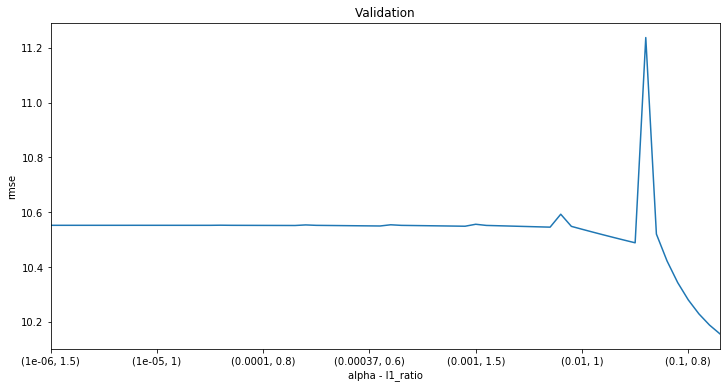

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train_scaled, Y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

alphas = [0.000001, 0.00001, 0.0001, 0.00037, 0.0005, 0.001, 0.01, 0.1]
l1_ratios = [1.5, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5]

cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1_ratio)).mean() 
            for (alpha, l1_ratio) in product(alphas, l1_ratios)]

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index = idx)
p_cv_elastic.plot(title = "Validation")
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")


elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)

elastic.fit(X_train_scaled, Y_train)

ElasticNet(alpha=0.005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#plt.savefig('elasticalpha.png')

Text(0.5, 1.0, 'Coefficients in the Elastic Net Model')

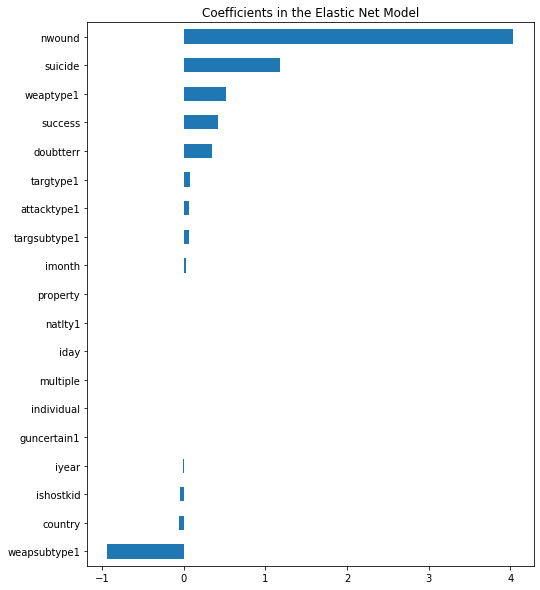

In [8]:
coef = pd.Series(elastic.coef_, index = data.loc[:, data.columns.difference(['nkill', 'eventid'])].columns)


imp_coef = pd.concat([coef.sort_values().head(25),
                     coef.sort_values().tail(0)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")
#plt.savefig('elasticcoefs.png')

In [9]:
#bin nkills for evaluation
# create a list of our conditions
conditions = [
    (data['nkill'] ==0),
    (data['nkill'] ==1),
    (data['nkill'] ==2),
    (data['nkill'] >=3) & (data['nkill']<=100),
    (data['nkill'] > 100),
    (data['nkill'].isnull())
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 2, 20, 100, None]

# create a new column and use np.select to assign values to it using our lists as arguments
data['nkill_binned'] = np.select(conditions, values)

# display updated DataFrame
data.head()

,eventid,iyear,imonth,iday,country,doubtterr,multiple,success,suicide,attacktype1,...,natlty1,guncertain1,individual,weaptype1,weapsubtype1,nwound,property,ishostkid,nkill,nkill_binned
96718,201005270004,2010,5,27,95,0,0,1,0,3,...,95.0,0.0,0,6,17.0,2.0,1,0.0,0.0,0
104352,201111300009,2011,11,30,95,0,0,1,0,3,...,95.0,0.0,0,6,15.0,7.0,-9,0.0,0.0,0
104347,201111290047,2011,11,28,43,0,0,1,0,3,...,43.0,0.0,0,6,17.0,0.0,0,0.0,0.0,0
104345,201111290042,2011,11,29,78,0,0,1,0,7,...,78.0,1.0,0,8,20.0,0.0,1,0.0,0.0,0
104342,201111290028,2011,11,29,209,1,0,1,0,3,...,209.0,0.0,0,6,16.0,5.0,1,0.0,0.0,0


In [29]:
#Select 7 features from elastic net
data_reduced = data[['nwound', 'suicide', 'weaptype1', 'success', 'doubtterr', 'targtype1','weapsubtype1', 'nkill_binned']]

data_reduced['nkill_binned'] = data_reduced['nkill_binned'].apply(lambda x: x if pd.isnull(x) else int(x))
data_train = data_reduced[data_reduced['nkill_binned'].notnull()]


#set aside rows with missing # of kills for imputation
data_impute = data_reduced[data_reduced['nkill_binned'].isnull()]

X = data_train.iloc[:, :-1].to_numpy()
Y = data_train['nkill_binned'].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=10, shuffle = True)


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#AdaBoost classifier

clf = AdaBoostClassifier(n_estimators=10, random_state=0)
clf.fit(X_train, Y_train)
Y_predict_ada = clf.predict(X_test)

mean_squared_error(Y_test, Y_predict_ada)

print(f"The misclassification number is {np.sum(Y_predict_ada!=Y_test)}.")

The misclassification number is 23108.


In [12]:
#neural network
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(solver='lbfgs', alpha=0.0001, hidden_layer_sizes=(6, 2), random_state=10, shuffle = True)
clf_nn.fit(X_train, Y_train)
Y_predict_nn = clf_nn.predict(X_test)

mean_squared_error(Y_test, Y_predict_nn)
print(f"The misclassification number is {np.sum(Y_predict_nn!=Y_test)}.")

The misclassification number is 20755.


In [13]:
#CART
from sklearn import tree
CART = tree.DecisionTreeClassifier()
CART = CART.fit(X_train, Y_train)

Y_predict_cart = CART.predict(X_test)

print(f"The misclassification number is {np.sum(Y_predict_cart!=Y_test)}.")

The misclassification number is 18750.


In [ ]:
#data_final = data_train.append(data_impute)

In [ ]:
#data_final.to_csv(r'data_final.csv', index = False)

In [31]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y_test, Y_predict_cart)

72.5383606436238

In [17]:
pd.crosstab(Y_test, Y_predict_ada, margins = True)

col_0,0.0,1.0,20.0,All
row_0,,,,
0.0,25592,0,2005,27597
1.0,9675,0,1946,11621
2.0,3348,1,1207,4556
20.0,4864,0,5431,10295
100.0,22,0,40,62
All,43501,1,10629,54131


In [18]:
pd.crosstab(Y_test, Y_predict_nn, margins = True)

col_0,0.0,1.0,20.0,All
row_0,,,,
0.0,22441,4075,1081,27597
1.0,3692,6698,1231,11621
2.0,1516,2205,835,4556
20.0,2518,3540,4237,10295
100.0,17,16,29,62
All,30184,16534,7413,54131


In [19]:
pd.crosstab(Y_test, Y_predict_cart, margins = True)

col_0,0.0,1.0,2.0,20.0,100.0,All
row_0,,,,,,
0.0,23942,2069,143,1442,1,27597
1.0,3963,5881,132,1645,0,11621
2.0,1695,1620,107,1134,0,4556
20.0,2695,1903,237,5444,16,10295
100.0,13,6,0,36,7,62
All,32308,11479,619,9701,24,54131


In [32]:
print('mean squared error ada: %.3f' % mean_squared_error(Y_test, Y_predict_ada))

print('mean squared error neural network: %.3f' % mean_squared_error(Y_test, Y_predict_nn))


print('mean squared error CART: %.3f' % mean_squared_error(Y_test, Y_predict_cart))

mean squared error ada: 80.180
mean squared error neural network: 73.173
mean squared error CART: 72.538


In [20]:
#Select 7 features from elastic net
data_reduced = data[['nwound', 'suicide', 'weaptype1', 'success', 'doubtterr', 'targtype1','weapsubtype1', 'nkill']]

data_reduced['nkill'] = data_reduced['nkill'].apply(lambda x: x if pd.isnull(x) else int(x))
data_train = data_reduced[data_reduced['nkill'].notnull()]


#set aside rows with missing # of kills for imputation
data_impute = data_reduced[data_reduced['nkill'].isnull()]

X = data_train.iloc[:, :-1].to_numpy()
Y = data_train['nkill'].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=10, shuffle = True)

In [25]:
#Linear regression
from sklearn.metrics import r2_score
linregressor = LinearRegression()  
linregressor.fit(X_train, Y_train)
Y_predict_linreg = linregressor.predict(X_test)
Y_predict_linreg1 = np.round(Y_predict_linreg,0)

print('mean squared error: %.3f' % mean_squared_error(Y_test, Y_predict_linreg1))

print('R^2 train: %.3f' %  r2_score(Y_test, Y_predict_linreg))

mean squared error: 76.264
R^2 train: 0.373


In [26]:
#impute values for nkill
data_impute = data_reduced[data_reduced['nkill'].isnull()]
data_impute = data_impute[data_impute.columns[:-1]]
Y_predict_impute = linregressor.predict(data_impute)

Y_predict_impute1 = np.round(Y_predict_impute , 0) 

In [27]:
Y_predict_impute1

array([1., 1., 1., ..., 3., 4., 4.])

In [28]:
linregressor.fit(X_train, Y_train)
Y_predict_linreg = linregressor.predict(X_test)
Y_predict_linreg_train = linregressor.predict(X_train)
train_mse = mean_squared_error(Y_train, Y_predict_linreg_train)
test_mse = mean_squared_error(Y_test, Y_predict_linreg)
r2 = r2_score(Y_test, Y_predict_linreg)
r2_train = r2_score(Y_train, Y_predict_linreg_train)
print(train_mse)
print(test_mse)
print(r2_train)
print(r2)

113.09211877031503
76.04615155843246
0.16347479828694855
0.37258767233143775
